<a href="https://colab.research.google.com/github/RodrigoGuedesDP/Computer_Vision/blob/main/cv_labo3_vgg16_emociones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Computer Vision – Clasificación de expresiones faciales con VGG16**

---



*   Este notebook desarrolla un clasificador de emociones faciales utilizando el modelo VGG16 preentrenado y el dataset público FER-2013. A lo largo del ejercicio se realiza la descarga y carga del dataset, la aplicación de transformaciones necesarias para VGG16, la modificación de la capa de salida del modelo y la congelación de las capas convolucionales. Finalmente, se entrena el modelo durante 5 épocas y se evalúa su rendimiento sobre el conjunto de prueba, presentando las métricas obtenidas y una breve interpretación de los resultados.



**Autores:**  

Nieto Espinoza, Brajan E.  
[brajan.nieto@utec.edu.pe](mailto:brajan.nieto@utec.edu.pe)

Guedes del Pozo,  Rodrigo J.  
[rodrigo.guedes.d@utec.edu.pe](mailto:rodrigo.guedes.d@utec.edu.pe)

<img src="https://pregrado.utec.edu.pe/sites/default/files/logo-utec-h_0_0.svg" width="190" alt="Logo UTEC" loading="lazy" typeof="foaf:Image">      

---

## **Descarga y verificación del dataset FER-2013**

Esta celda instala KaggleHub, descarga automáticamente el dataset FER-2013 y verifica su estructura. Además, identifica las carpetas de entrenamiento y prueba para preparar los directorios que se utilizarán más adelante en la carga de datos.


In [ ]:
!pip install -q kagglehub
import kagglehub
import os

path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)
print("Contents at that path:", os.listdir(path))
contents = os.listdir(path)
if "train" in contents and "test" in contents:
    data_dir = path
elif "fer2013" in contents:
    data_dir = os.path.join(path, "fer2013")
else:
    raise RuntimeError(
        "Could not find 'train' and 'test' folders. "
        "Check the printed contents and adjust data_dir manually."
    )

train_dir = os.path.join(data_dir, "train")
test_dir  = os.path.join(data_dir, "test")

print("Train dir:", train_dir)
print("Test dir :", test_dir)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013
Contents at that path: ['test', 'train']
Train dir: /kaggle/input/fer2013/train
Test dir : /kaggle/input/fer2013/test


## **Carga inicial del dataset con ImageFolder**

En esta celda se cargan las imágenes de entrenamiento y prueba utilizando `datasets.ImageFolder` a partir de las rutas obtenidas con KaggleHub. También se muestran las clases disponibles y la cantidad total de imágenes en cada conjunto para confirmar que los datos fueron cargados correctamente.


In [ ]:
# cargar datasets con ImageFolder usando los paths de kagglehub
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

print("Using train_dir:", train_dir)
print("Using test_dir :", test_dir)

raw_train_dataset = datasets.ImageFolder(root=train_dir)
raw_test_dataset  = datasets.ImageFolder(root=test_dir)

print("Classes:", raw_train_dataset.classes)
print("Train images:", len(raw_train_dataset))
print("Test images:", len(raw_test_dataset))

Using train_dir: /kaggle/input/fer2013/train
Using test_dir : /kaggle/input/fer2013/test
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train images: 28709
Test images: 7178


## **Transformaciones para VGG16 y creación de DataLoaders**

En esta celda se aplican las transformaciones necesarias para adaptar las imágenes del dataset FER-2013 al formato esperado por VGG16, incluyendo conversión a 3 canales, redimensionamiento y normalización con los valores de ImageNet. Además, se divide el conjunto de entrenamiento en entrenamiento y validación, y se crean los DataLoaders correspondientes para cada partición.


In [ ]:
# Aplicar transformaciones necesarias para VGG16 y crear DataLoaders
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


train_dataset_full = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset       = datasets.ImageFolder(root=test_dir,  transform=test_transform)

class_names = train_dataset_full.classes
print("Classes:", class_names)

val_ratio = 0.2
val_size  = int(len(train_dataset_full) * val_ratio)
train_size = len(train_dataset_full) - val_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}")

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train size: 22968
Val size:   5741
Test size:  7178


## **Carga del modelo VGG16 preentrenado**

En esta celda se carga el modelo VGG16 preentrenado en ImageNet, utilizando los pesos oficiales de PyTorch cuando están disponibles. También se configura el dispositivo de cómputo (CPU o GPU) y se mueve el modelo a dicho dispositivo para su posterior entrenamiento.


In [ ]:
# Cargar el modelo VGG16 preentrenado en ImageNet

import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

try:
    weights = models.VGG16_Weights.IMAGENET1K_V1
    vgg16 = models.vgg16(weights=weights)
except:
    vgg16 = models.vgg16(pretrained=True)

print(vgg16)
vgg16 = vgg16.to(device)

Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 181MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## **Modificación de la capa de salida para clasificar 7 emociones**

En esta celda se reemplaza la última capa totalmente conectada del modelo VGG16 para ajustar la arquitectura al problema de clasificación de expresiones faciales. La nueva capa de salida genera 7 probabilidades correspondientes a las emociones del dataset FER-2013.

In [ ]:
# Reemplazar la capa de salida para clasificar 7 emociones

num_classes = 7  # angry, disgust, fear, happy, neutral, sad, surprise
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(in_features, num_classes)

vgg16 = vgg16.to(device)

print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=7, bias=True)
)


## **Congelación de las capas convolucionales del modelo VGG16**

En esta celda se congelan todas las capas de la sección `features` del modelo VGG16, evitando que sus pesos se actualicen durante el entrenamiento. Esto permite entrenar únicamente la capa final recién añadida, reduciendo el costo computacional y aprovechando el aprendizaje previo del modelo. También se muestra la cantidad de parámetros entrenables frente al total.

In [ ]:
# Congelar las capas convolucionales (features)

for param in vgg16.features.parameters():
    param.requires_grad = False

trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in vgg16.parameters())
print(f"Trainable params: {trainable_params} / {total_params}")


Trainable params: 119574535 / 134289223


## **Entrenamiento del modelo durante 5 épocas**

Esta celda ejecuta el proceso completo de entrenamiento del modelo VGG16 modificado durante 5 épocas. Incluye el cálculo de la pérdida y exactitud en el conjunto de entrenamiento, seguido de la evaluación en el conjunto de validación en cada época. Se usan Adam como optimizador y CrossEntropyLoss como función de pérdida. Al final de cada época se reportan las métricas de desempeño.


In [ ]:
# Entrenar durante 5 épocas

import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, vgg16.parameters()),
    lr=1e-4
)

num_epochs = 5

for epoch in range(num_epochs):
    # ---- Train ----
    vgg16.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_corrects / total_samples

    # ---- Validation ----
    vgg16.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = vgg16(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * images.size(0)
            val_running_corrects += (preds == labels).sum().item()
            val_total_samples += labels.size(0)

    val_loss = val_running_loss / val_total_samples
    val_acc  = val_running_corrects / val_total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train loss: {epoch_loss:.4f} | Train acc: {epoch_acc:.4f} "
          f"| Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")


Epoch [1/5] Train loss: 1.4073 | Train acc: 0.4593 | Val loss: 1.2453 | Val acc: 0.5307
Epoch [2/5] Train loss: 1.1554 | Train acc: 0.5670 | Val loss: 1.1872 | Val acc: 0.5581
Epoch [3/5] Train loss: 1.0018 | Train acc: 0.6293 | Val loss: 1.1577 | Val acc: 0.5715
Epoch [4/5] Train loss: 0.8497 | Train acc: 0.6918 | Val loss: 1.1510 | Val acc: 0.5748
Epoch [5/5] Train loss: 0.6903 | Train acc: 0.7547 | Val loss: 1.1878 | Val acc: 0.5893


## **Evaluación del modelo en el conjunto de prueba y métricas finales**

En esta celda se evalúa el rendimiento final del modelo VGG16 utilizando el conjunto de prueba. Se calculan las predicciones, la exactitud global y el reporte de clasificación para cada emoción. Además, se genera una matriz de confusión para visualizar los aciertos y errores del modelo entre las 7 clases del dataset FER-2013.


Test accuracy: 0.5848

Classification report:
              precision    recall  f1-score   support

       angry       0.46      0.52      0.48       958
     disgust       0.63      0.43      0.51       111
        fear       0.48      0.38      0.42      1024
       happy       0.81      0.73      0.77      1774
     neutral       0.61      0.45      0.52      1233
         sad       0.43      0.64      0.51      1247
    surprise       0.75      0.74      0.75       831

    accuracy                           0.58      7178
   macro avg       0.60      0.56      0.57      7178
weighted avg       0.61      0.58      0.59      7178



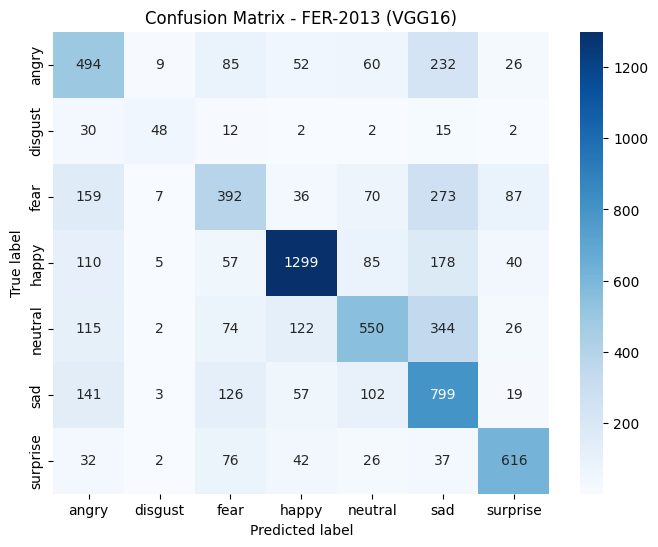

In [ ]:
# Evaluar el rendimiento sobre el conjunto de prueba y mostrar métricas

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

vgg16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {test_acc:.4f}\n")

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - FER-2013 (VGG16)')
plt.show()

## 1. Principal ventaja de usar VGG16 pre-entrenado

La principal ventaja de usar el VGG16 fue entrenado previamente en un dataset masivo como ImageNet, compuesto por millones de imágenes y cientos de clases. Gracias a esto, sus capas convolucionales ya han aprendido a detectar patrones visuales generales como bordes, texturas, formas y estructuras faciales básicas. Al reutilizar estas capas en lugar de entrenar desde cero:

- Se necesitan muchos menos datos específicos del dataset FER-2013 para lograr buen desempeño. Se redujeron los parámetros entrenables y con solo 5 épocas y 28709 imagenes de entrenamietno se alcanzó una precisiópn de 58.48% en test.  
- El entrenamiento es más rápido, ya que solo se ajustan las capas finales del clasificador. En solo 5 epocas, el modelo pasó de 45.93% a 75.47/ de precisión, demostrando que el conocimiento previo acelera significativamente el aprendizaje.  
- Se reduce el riesgo de sobreajuste, porque las primeras capas ya están regularizadas gracias al entrenamiento previo.

En resumen, el modelo aprovecha conocimiento visual general aprendido previamente, permitiendo una mejor representación inicial y evitando comenzar “desde cero”.

---


## 2. ¿Cómo se elige el número de neuronas en la capa de salida?

En un problema de clasificación, el número de neuronas en la capa de salida se define directamente por la cantidad de clases que se desean predecir. En el dataset FER-2013 existen **7 emociones** (angry, disgust, fear, happy, neutral, sad, surprise), por lo que la capa final se configura con **7 neuronas**, una para cada clase. Estas generan los valores (logits) que luego se transforman en probabilidades mediante la función softmax implícita en *CrossEntropyLoss*.


Es decir:

**Número de neuronas en la salida = número de clases del problema.**

Esta configuración permite que el modelo aprenda a mapear las características extraídas por las capas anteriores hacia las probabilidades de cada una de las 7 emociones, facilitando la clasificación multiclase.
---

